# Loan DeFault Detection

Build a model to identify loan default based on the histotical data, which enables financial institutions, banks, and insurance companies to optimize lending decisions, reduce financial risks, and enhance profitability

In [1]:
# import libraries we will need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings("ignore")

## 1. Load the data

In [2]:
raw =pd.read_csv('loans50k.csv',encoding='latin1')

### data at a glance

In [3]:
raw.head()

,loanID,amount,term,rate,payment,grade,employment,length,home,income,...,totalBal,totalRevLim,accOpen24,avgBal,bcOpen,bcRatio,totalLim,totalRevBal,totalBcLim,totalIlLim
0,188861,8000.0,36 months,0.14,272.07,C,Warehouseman,3 years,RENT,49966.0,...,48054.0,8100.0,8.0,4369.0,43.0,95.7,60629.0,48054.0,1000.0,52529.0
1,517703,11000.0,36 months,0.10,354.89,B,Vice President,10+ years,MORTGAGE,50000.0,...,265838.0,33400.0,4.0,22153.0,19756.0,37.5,297500.0,11844.0,31600.0,0.0
2,268587,35000.0,36 months,0.15,1220.33,D,Owner/Attorney,10+ years,RENT,360000.0,...,850150.0,83000.0,2.0,121450.0,7686.0,83.2,907300.0,173260.0,83000.0,100000.0
3,579902,20000.0,60 months,0.12,447.83,C,Analyst,2 years,MORTGAGE,60000.0,...,20671.0,14200.0,8.0,1723.0,11061.0,1.2,46964.0,20671.0,11200.0,32764.0
4,617630,12000.0,60 months,0.12,266.88,B,medical technician,10+ years,MORTGAGE,64000.0,...,128034.0,14600.0,3.0,18291.0,5904.0,58.4,134600.0,8475.0,14200.0,0.0


In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   loanID       50000 non-null  int64  
 1   amount       49999 non-null  float64
 2   term         49999 non-null  object 
 3   rate         49999 non-null  float64
 4   payment      49999 non-null  float64
 5   grade        49999 non-null  object 
 6   employment   47215 non-null  object 
 7   length       47319 non-null  object 
 8   home         49999 non-null  object 
 9   income       49999 non-null  float64
 10  verified     49999 non-null  object 
 11  status       49999 non-null  object 
 12  reason       49999 non-null  object 
 13  state        49999 non-null  object 
 14  debtIncRat   49999 non-null  float64
 15  delinq2yr    49999 non-null  float64
 16  inq6mth      49999 non-null  float64
 17  openAcc      49999 non-null  float64
 18  pubRec       49999 non-null  float64
 19  revo

### Feature Description

Target:

- status	loan status: DEFAULT, CURRENT, CHARGED OFF, etc.

Categorical:
- term:	 loan term is 36 or 60 months
- grade:	grade of loan: A is least risk, G is most risk
- employment:	job title of applicant
- length:	time continuously employed
- home:	home ownership: rent, own, mortgage
- verified:	verification status of annual income
- reason:	applicants purpose for the loan
- state:	two letter state code of applicant

Numerical:
- amount:	loan amount in dollars
- rate:	interest rate as a decimal
- payment:	monthly payment amount
- income:	annual income in dollars
- debtIncRat:	ratio monthly non-mortgage debt payment to monthly income
- delinq2yr:	number of 30+ day late payments in last two years
- inq6mth:	number of credit checks in the past 6 months
- openAcc:	number of open credit lines
- pubRec:	number of derogatory public records including bankruptcy filings, tax liens, etc.
- revolRatio:	proportion of revoling credit in use
- totalAcc:	total number of credit lines in file, includes both open and closed accounts
- totalPaid:	total amount repaid to bank (THIS IS NOT A PREDICTOR SINCE IT CAN ONLY BE DETERMINED AFTER A LOAN IS ISSUED)
- totalBal:	total current balance of all credit accounts
- totalRevLim:	sum of credit limits from all credit lines
- accOpen24:	how many accounts were opened in the past 24 months
- avgBal:	average balance per account
- bcOpen:	total unused credit on credit cards
- bcRatio:	ratio of total credit card balance to total credit card lmits
- totalLim:	total credit limits
- totalRevBal:	total credit balance except mortgages
- totalBcLim:	total credit limits of credit cards
- totalIlLim:	total of credit limits for installment accounts

## 2. Data preprocessing

### a. missing value

In [5]:
temp_null=raw.isnull().sum()
#total=loan.isnull().count()
total=len(raw)
percent=temp_null/total
missing_data=pd.concat([temp_null,percent],axis=1,keys=['temp_null','percent'])
missing_data

,temp_null,percent
loanID,0,0.00000
amount,1,0.00002
term,1,0.00002
rate,1,0.00002
payment,1,0.00002
grade,1,0.00002
employment,2785,0.05570
length,2681,0.05362
home,1,0.00002
income,1,0.00002


In [6]:
# since the total missing data is around 5% mainly on empoyment type and length, replace the missing data by unknown.
raw['employment'] = raw['employment'].fillna('unknown_employment')
raw['length'] = raw['length'].fillna('unknown_length')

# drop other missing data
raw = raw.dropna()
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49479 entries, 0 to 49999
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   loanID       49479 non-null  int64  
 1   amount       49479 non-null  float64
 2   term         49479 non-null  object 
 3   rate         49479 non-null  float64
 4   payment      49479 non-null  float64
 5   grade        49479 non-null  object 
 6   employment   49479 non-null  object 
 7   length       49479 non-null  object 
 8   home         49479 non-null  object 
 9   income       49479 non-null  float64
 10  verified     49479 non-null  object 
 11  status       49479 non-null  object 
 12  reason       49479 non-null  object 
 13  state        49479 non-null  object 
 14  debtIncRat   49479 non-null  float64
 15  delinq2yr    49479 non-null  float64
 16  inq6mth      49479 non-null  float64
 17  openAcc      49479 non-null  float64
 18  pubRec       49479 non-null  float64
 19  revo

In [7]:
# drop loanID
df=raw.drop(['loanID'], axis=1)

### b. Target

In [8]:
df.status.value_counts().rename_axis('unique_values').reset_index(name='counts')

,unique_values,counts
0,Fully Paid,26767
1,Current,14405
2,Charged Off,7502
3,Late (31-120 days),446
4,In Grace Period,257
5,Late (16-30 days),100
6,Default,2


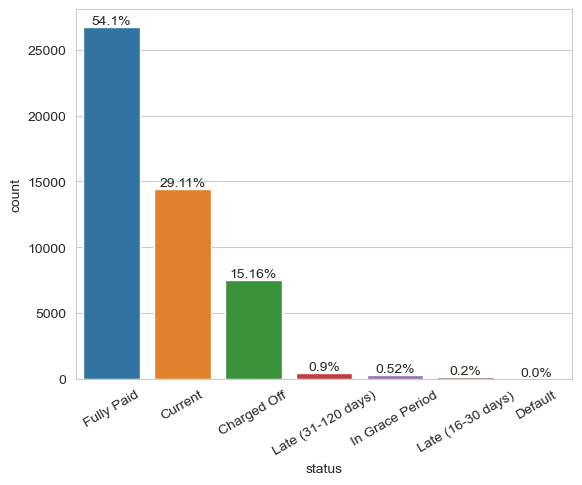

In [9]:
ax = sns.countplot(x=df['status'],
                   order=df['status'].value_counts(ascending=False).index);
        
abs_values = df['status'].value_counts(ascending=False)
rel_values = df.status.value_counts(normalize=True).mul(100).round(2).astype(str) + '%'
#lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=rel_values)

plt.xticks(rotation=30)
plt.show()

Based on the dicussion in https://lakeviewlawgroup.com/blog/delinquency-and-charge-off/, we define 'charge off' and 'Default' as 1, and the rest as 0.

In [10]:
df['status'] = df['status'].replace(['Fully Paid', 'In Grace Period', 'Current','Late (16-30 days)','Late (31-120 days)'], float(0))
df['status'] = df['status'].replace(['Charged Off', 'Default'], float(1))

df['status'].value_counts(normalize=True)

0.0    0.84834
1.0    0.15166
Name: status, dtype: float64

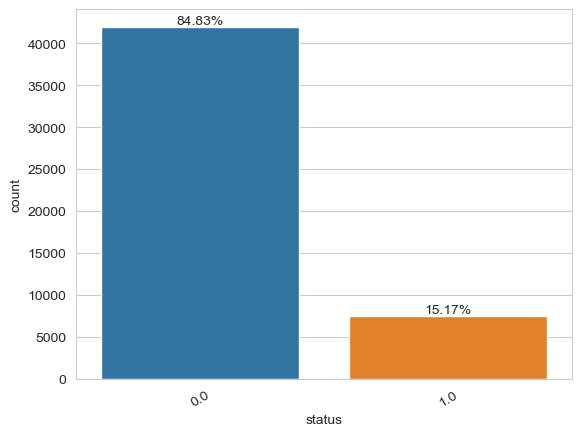

In [11]:
ax = sns.countplot(x=df['status'],
                   order=df['status'].value_counts(ascending=False).index);
        
rel_values = df.status.value_counts(normalize=True).mul(100).round(2).astype(str) + '%'
ax.bar_label(container=ax.containers[0], labels=rel_values)

plt.xticks(rotation=30)
plt.show()

This data set seems imbalanced. Need to use class weight = balanced or other strategies such as SMOTE to counter the imbalance

### c. features

#### Categorical:
- term:	loan term is 36 or 60 months
- grade:	grade of loan: A is least risk, G is most risk
- employment:	job title of applicant
- length:	time continuously employed
- home:	home ownership: rent, own, mortgage
- verified:	verification status of annual income
- reason:	applicants purpose for the loan
- state:	two letter state code of applicant

In [12]:
df['home'].value_counts()

MORTGAGE    24786
RENT        19501
OWN          5192
Name: home, dtype: int64

In [13]:
df.groupby('home').status.value_counts(normalize=True)

home      status
MORTGAGE  0.0       0.867869
          1.0       0.132131
OWN       0.0       0.847843
          1.0       0.152157
RENT      0.0       0.823650
          1.0       0.176350
Name: status, dtype: float64

In [14]:
df['employment'].value_counts()

unknown_employment             2743
Teacher                         924
Manager                         806
RN                              402
Registered Nurse                386
                               ... 
house officer                     1
Kitchen Maneger                   1
Network Systems Analyst III       1
Sr CAD Operator                   1
welding tech                      1
Name: employment, Length: 21213, dtype: int64

In [15]:
df['reason'].value_counts()

debt_consolidation    29648
credit_card           11837
home_improvement       2890
other                  2168
major_purchase          891
medical                 491
small_business          431
car                     375
moving                  282
vacation                266
house                   162
renewable_energy         36
wedding                   2
Name: reason, dtype: int64

In [16]:
df.groupby('reason').status.value_counts(normalize=True)

reason              status
car                 0.0       0.885333
                    1.0       0.114667
credit_card         0.0       0.875222
                    1.0       0.124778
debt_consolidation  0.0       0.839955
                    1.0       0.160045
home_improvement    0.0       0.860208
                    1.0       0.139792
house               0.0       0.827160
                    1.0       0.172840
major_purchase      0.0       0.858586
                    1.0       0.141414
medical             0.0       0.810591
                    1.0       0.189409
moving              0.0       0.783688
                    1.0       0.216312
other               0.0       0.831642
                    1.0       0.168358
renewable_energy    0.0       0.833333
                    1.0       0.166667
small_business      0.0       0.742459
                    1.0       0.257541
vacation            0.0       0.830827
                    1.0       0.169173
wedding             0.0       1.00000

In [17]:
df['grade'].value_counts()

C    13981
B    13650
A     8162
D     8065
E     4135
F     1214
G      272
Name: grade, dtype: int64

In [18]:
df.groupby('grade').status.value_counts(normalize=True)

grade  status
A      0.0       0.952340
       1.0       0.047660
B      0.0       0.908352
       1.0       0.091648
C      0.0       0.838352
       1.0       0.161648
D      0.0       0.769250
       1.0       0.230750
E      0.0       0.715357
       1.0       0.284643
F      0.0       0.629325
       1.0       0.370675
G      0.0       0.573529
       1.0       0.426471
Name: status, dtype: float64

In [19]:
df.groupby('term').status.value_counts(normalize=True)

term        status
 36 months  0.0       0.869818
            1.0       0.130182
 60 months  0.0       0.803790
            1.0       0.196210
Name: status, dtype: float64

In [20]:
df.groupby('state').status.value_counts(normalize=True)

state  status
AK     0.0       0.787611
       1.0       0.212389
AL     0.0       0.826156
       1.0       0.173844
AR     0.0       0.824000
                   ...   
WI     1.0       0.142424
WV     0.0       0.853933
       1.0       0.146067
WY     0.0       0.861702
       1.0       0.138298
Name: status, Length: 98, dtype: float64

In [21]:
df.groupby('verified').status.value_counts(normalize=True)

verified         status
Not Verified     0.0       0.885632
                 1.0       0.114368
Source Verified  0.0       0.844363
                 1.0       0.155637
Verified         0.0       0.816974
                 1.0       0.183026
Name: status, dtype: float64

 Employment feature will not be used since there are not specific to certain type of employment. 
 TotalPaid will not be used because it can only be determined after a loan is issued.
 LoanID and State will be dropped since it contains the state info of the borrower and has too many categorical values that are not related with default information. 

#### transform the numeric,ordinal, category data

In [22]:
class Transformer(object):
    def __init__(self):
        self.mean = 0
     
    def fit(self, X, y=None): 
        
        df['length'] = X.length.map(self.length2num)
        df['term'] = X.term.map(self.term2num)
        df['employment'] = X.employment.map(self.employment2num)
        df['state'] = X.state.map(self.state2num)
   
        # for home,reason,verified 
        self.home_count = X.home.value_counts()
        self.reason_count = X.reason.value_counts()
        self.verified_count = X.verified.value_counts()
    
       
    def transform(self, X, y=None):
               
        #for home, reason,verified,grade
        df['home'] = X.home.map(lambda x: self.home_count[x])
        df['reason'] = X.reason.map(lambda x: self.reason_count[x])
        df['verified'] = X.verified.map(lambda x: self.verified_count[x])
        df['grade'] = X.grade.map(self.grade_score)
        # for length, term, employment,state
        df['length'] = X.length.map(self.length2num)
        df['term'] = X.term.map(self.term2num)
#        df['employment'] = X.employment.map(self.employment2num)
        df['state'] = X.state.map(self.state2num)
 
        
        return df[['term','rate','payment','amount','grade','length','home', 'income','verified', 'reason', 'debtIncRat', 'state',
                    'delinq2yr', 'inq6mth', 'openAcc', 'pubRec', 'revolRatio', 'totalAcc', 'totalBal', 'totalRevLim', 
                    'totalLim', 'accOpen24', 'avgBal', 'bcOpen', 'bcRatio', 'totalRevBal', 'totalBcLim', 'totalIlLim','status']]
            
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)
    
    def length2num(self, x):
        if type(x) == str and x == 'unknown_length':
            x = x.strip('unknown_length')
            x = float(0)
        if type(x) == str:
            x = x.strip('years')
            if x == '10+ ':
                x = x.split('+')
                x = float(x[0])
            elif x == '< 1 ':
                x = x.split(' ')
                x = float(x[1])
            else:
                x = float(x)
        return x
    
    def term2num(self, x):
        if type(x) == str:
            x = x.strip('months')
        return float(x)
    
    
    def employment2num(self, x):
        if type(x) == str and x =='unkown_employement':
            x = x.strip('unknown_length')
            x = float(1)
            
        elif type(x) == str:
            x = float(0)
        return x
    
    def state2num(self, x):
        if type(x) == str and x == 'CA':
            x = float(3)
        elif type(x) == str and x == 'NY' or x =='TX' or x == 'FL':
            x = float(2)
        elif type(x) == str:
            x = float(1)
        return x
        
    
    def grade_score(self, x):
        if x == 'C':
            return 0.047660
        if x == 'B':
            return 0.091648
        if x == 'A':
            return  0.161648
        if x == 'D':
            return 0.230750
        if x == 'E':
            return 0.284643
        if x == 'F':
            return 0.370675
        if x == 'G':
            return 0.426471
        

In [23]:
trans=Transformer()
loan=trans.fit_transform(df)

In [24]:
loan.grade

0        0.047660
1        0.091648
2        0.230750
3        0.047660
4        0.091648
           ...   
49995    0.047660
49996    0.370675
49997    0.091648
49998    0.091648
49999    0.091648
Name: grade, Length: 49479, dtype: float64

In [25]:
trans.grade_score(df.grade[0])

## 3 Train test split
The first step in predictive modeling is performing a train test split. Perform a train test split on these data, setting aside  20% of the data as a test set. Choose a random_state so your results are reproducible.

In [26]:
from sklearn.model_selection import train_test_split
loan_train, loan_test = train_test_split(loan,
                                      test_size=0.2,
                                      stratify = loan['status'],
                                      random_state= 42)

## 4. Exploratory data analysis (EDA)

After the train test split we can work on some exploratory data analysis. Here is where we start to look at the data and see if we can generate any modeling ideas or hypotheses. You will make a series of plots and learn a modeling trick that should improve any models we make.

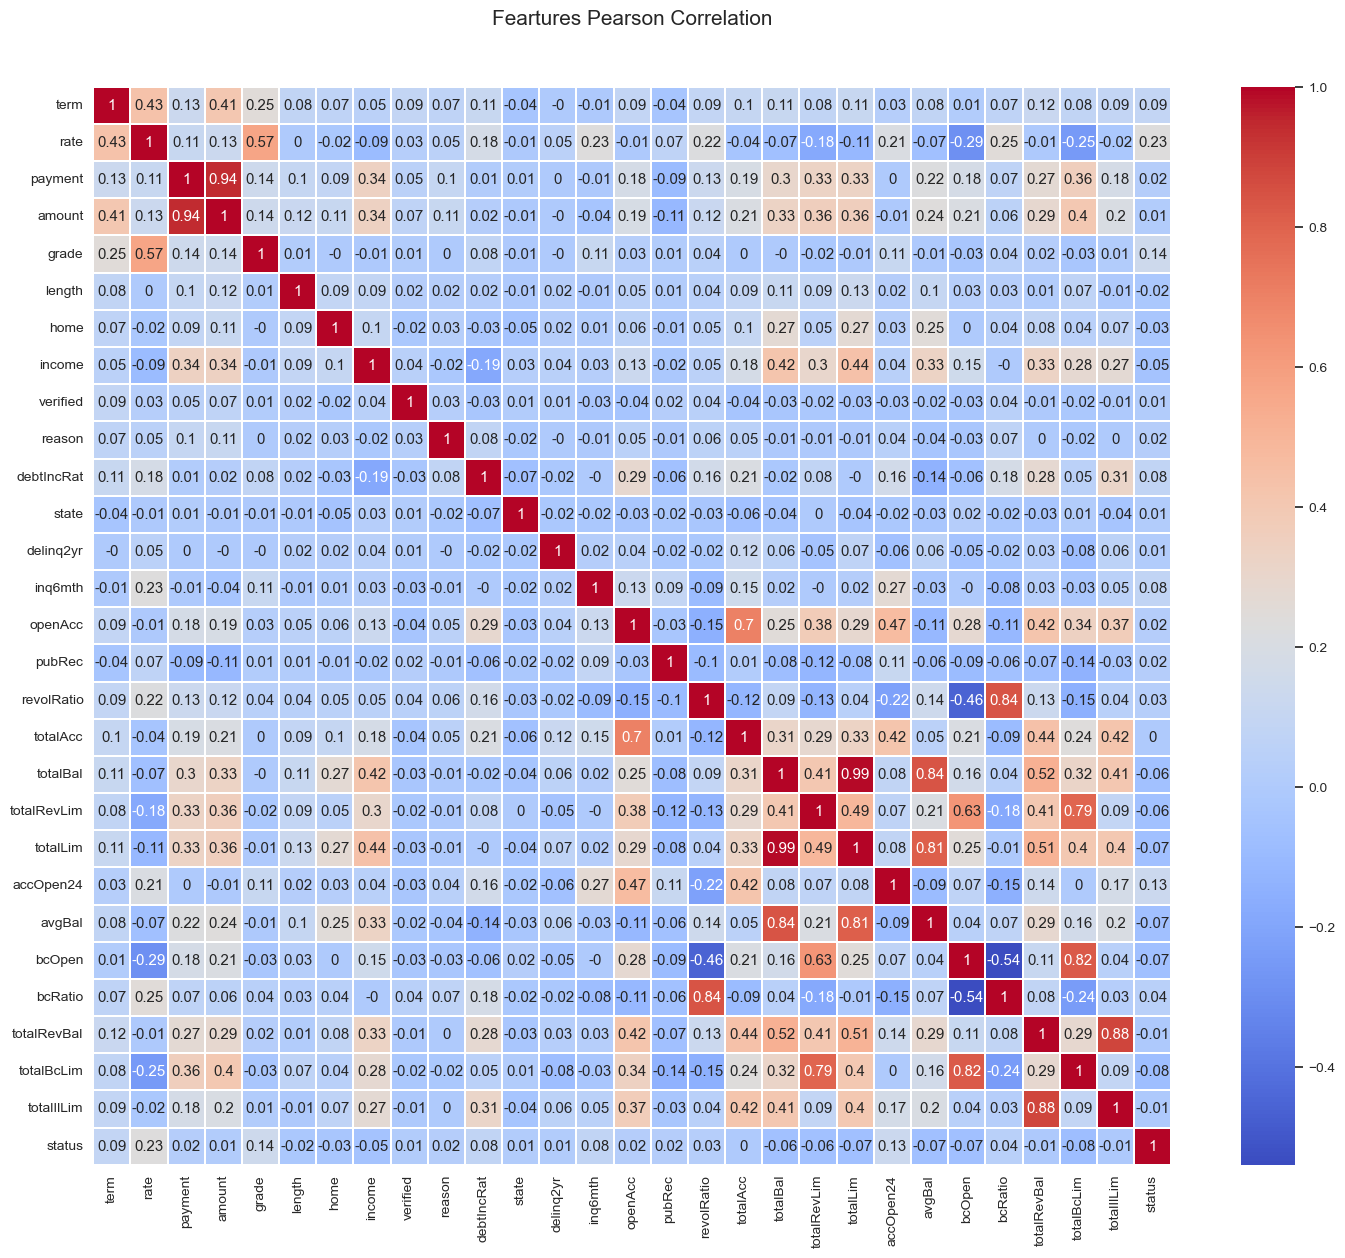

In [27]:
correlation = loan.astype(float).corr(method='pearson')
colormap = plt.cm.RdBu
    
plt.figure(figsize=(18,14))
plt.title('Feartures Pearson Correlation', y=1.05, size=15)
sns.set(font_scale=0.9)
sns.heatmap(round(correlation,2),linewidths=0.1,vmax=1.0, square=True,  
                cmap='coolwarm', linecolor='white', annot=True)
plt.show()


Text(0.5, 1.0, 'Correlation with TARGET variable')

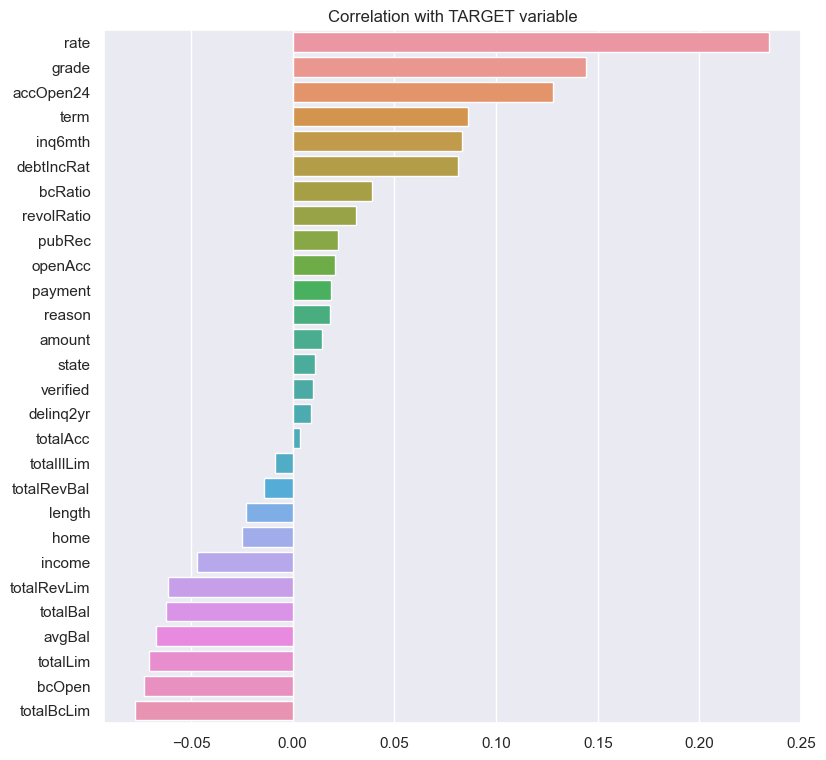

In [28]:
sns.set(font_scale=1)
corr_with_status = loan.corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(9, 9))
sns.barplot(x=corr_with_status.values, y=corr_with_status.index)
plt.title('Correlation with TARGET variable')

## Feature Engineering
From Pearson correlation map, payment and amount highly correlated, remove amount.
TatalLim and totalBal are highly correlated, create new feature using these two: DTI  

In [29]:
Loan = loan.drop(columns=['debtIncRat','totalLim', 'amount'])
  

In [30]:
loan['DTI'] = loan['totalBal']/loan['totalLim']

In [31]:
loan.head(5)

,term,rate,payment,amount,grade,length,home,income,verified,reason,...,totalLim,accOpen24,avgBal,bcOpen,bcRatio,totalRevBal,totalBcLim,totalIlLim,status,DTI
0,36.0,0.14,272.07,8000.0,0.047660,3.0,19501,49966.0,20914,11837,...,60629.0,8.0,4369.0,43.0,95.7,48054.0,1000.0,52529.0,1.0,0.792591
1,36.0,0.10,354.89,11000.0,0.091648,10.0,24786,50000.0,14261,29648,...,297500.0,4.0,22153.0,19756.0,37.5,11844.0,31600.0,0.0,0.0,0.893573
2,36.0,0.15,1220.33,35000.0,0.230750,10.0,19501,360000.0,14304,29648,...,907300.0,2.0,121450.0,7686.0,83.2,173260.0,83000.0,100000.0,0.0,0.937011
3,60.0,0.12,447.83,20000.0,0.047660,2.0,24786,60000.0,20914,29648,...,46964.0,8.0,1723.0,11061.0,1.2,20671.0,11200.0,32764.0,0.0,0.440146
4,60.0,0.12,266.88,12000.0,0.091648,10.0,24786,64000.0,20914,29648,...,134600.0,3.0,18291.0,5904.0,58.4,8475.0,14200.0,0.0,0.0,0.951218


## 5. Metric selection

For this problem accuracy is not a good metric because the classes are imbalanced so we will choose AUC-ROC

## 6. Initial modeling attempts

Here we will choose Logistic Regression, Random Forest, and XGBoost since all of them can deal with imbalance dataset well and have good interpretability.

perform 5-fold cross-validation for model comparison.

In [37]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc, roc_curve,roc_auc_score

In [33]:
n_splits = 5

kfold = StratifiedKFold(n_splits,
                           shuffle=True,
                           random_state=498)

In [34]:
features = ['term','rate','payment','amount','grade','length','home', 'income','verified', 'reason', 'debtIncRat', 'state',
                    'delinq2yr', 'inq6mth', 'openAcc', 'pubRec', 'revolRatio', 'totalAcc', 'totalBal', 'totalRevLim', 
                    'totalLim', 'accOpen24', 'avgBal', 'bcOpen', 'bcRatio', 'totalRevBal', 'totalBcLim', 'totalIlLim']

### logistic regression

In [35]:
from sklearn.linear_model import LogisticRegression

In [38]:
full_log_accs = np.zeros(n_splits)

i = 0
for train_index, test_index in kfold.split(loan_train, loan_train.status):
    loan_tt = loan_train.iloc[train_index]
    loan_ho = loan_train.iloc[test_index]
    
    log_reg = LogisticRegression(penalty=None,
                                 class_weight = 'balanced',
                                     max_iter = 1000)
        
    log_reg.fit(loan_tt[features].values,
                   loan_tt.status.values)
        
    pred = log_reg.predict(loan_ho[features].values)
    
    full_log_accs[i] = roc_auc_score(loan_ho.status.values,
                                              pred)
    
    i = i + 1

In [39]:
np.mean(full_log_accs)

0.5983828050445025

### Random Forest

We will tune the `max_depth` and `n_estimators` hyperparameters of a random forest model with `GridSearchCV`.

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [42]:
max_depths = range(1, 11)
n_trees = [100, 500]

In [44]:
rf_grid_cv = GridSearchCV(RandomForestClassifier(class_weight = 'balanced'), # first put the model object here
                          param_grid = {'max_depth':max_depths, # place the grid values for max_depth and
                                        'n_estimators':n_trees}, # and n_estimators here
                          scoring = 'roc_auc', # put the metric we are trying to optimize here as a string, ‘roc_auc’
                          cv = 5) # put the number of cv splits here

## you fit it just like a model
rf_grid_cv.fit(loan_train[features], loan_train.status)

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'max_depth': range(1, 11), 'n_estimators': [100, 500]},
             scoring='roc_auc')

In [46]:
## .best_params_
rf_grid_cv.best_params_

{'max_depth': 6, 'n_estimators': 500}

In [48]:
rf_grid_cv.best_score_

0.6968868978220618

### XGBoost

In [49]:
from xgboost import XGBClassifier

In [72]:
scale_pos_weight = loan_train.status.value_counts()[0] / loan_train.status.value_counts()[1]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_cv= GridSearchCV(XGBClassifier(scale_pos_weight=scale_pos_weight),  
                     param_grid = {'max_depth': [3,5,7],  
                                   'n_estimators': [100,200,300,400,500],  
                                   'learning_rate':[0.01,0.05,0.1,0.2]},  
                     scoring = 'roc_auc',  
                     cv = cv )  

xgb_cv.fit(loan_train[features], loan_train.status)  

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='roc_auc')

In [73]:
xgb_cv.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}

In [75]:
xgb_cv.best_score_

0.6996232053908488

In [80]:
pd.DataFrame({'feature_importance_score':xgb_cv.best_estimator_.feature_importances_},
                 index=features).sort_values('feature_importance_score',
                                                ascending=False)

,feature_importance_score
rate,0.292048
grade,0.122553
accOpen24,0.048403
totalLim,0.048202
avgBal,0.043136
totalBal,0.029647
debtIncRat,0.028626
home,0.028078
totalBcLim,0.026640
income,0.024968


### Model selection

In [54]:
pd.DataFrame({'Model': ['Logistic Regression',
                          'Random Forest', 
                        'XGBoost'],
                   'roc_auc': [0.598,0.696,0.700]}).sort_values('roc_auc')

,Model,roc_auc
0,Logistic Regression,0.598
1,Random Forest,0.696
2,XGBoost,0.700


## 7 Evaluating the test performance

Based on the above, the bestperforming model is XGBoost with {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}

###  fit the model on the entire train set

In [76]:
best_model=xgb_cv.best_estimator_

In [77]:
best_model.fit(loan_train[features], loan_train.status)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [78]:
print("Training roc_auc:", roc_auc_score(loan_train.status, best_model.predict(loan_train[features])))

Training roc_auc: 0.6580964084167962


In [79]:
print("Training roc_auc:", roc_auc_score(loan_test.status, best_model.predict(loan_test[features])))

Training roc_auc: 0.6545821546802827
